In [1]:
import os 
os.chdir("/nas/ucb/oliveradk/diverse-gen/")

from collections import defaultdict
import itertools

import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 

from utils.exp_utils import get_conf_dir
from utils.proc_data_utils import get_exp_metrics, get_max_acc, get_acc_results



In [2]:
OUT_DIR = "output/cc_mix_rate_sweep_all/final"
RESULTS_DIR = "experiments/250122_cc/results"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [3]:
MIX_RATES = [0.1, 0.25, 0.5, 0.75, 1.0]
DATASETS = ["toy_grid", "fmnist_mnist", "cifar_mnist", "waterbirds", "celebA-0", "multi-nli"]
METHODS = ["DivDis", "TopK 0.5", "TopK 0.1", "DBAT", "ERM"]
SEEDS = [1, 2, 3]



In [4]:
def get_results(acc_metric: str, model_selection="val_loss"):
    results = defaultdict(lambda: defaultdict(list))
    for dataset, method in itertools.product(DATASETS, METHODS):
        exp_dirs = []
        mix_rates = MIX_RATES if method != "ERM" else [0.0]
        for mix_rate, seed in itertools.product(mix_rates, SEEDS):
            exp_dirs.append(get_conf_dir((dataset, method, mix_rate, seed), OUT_DIR))
        perf_source_acc = dataset == "toy_grid"
        results[dataset][method] = get_acc_results(
            exp_dirs=exp_dirs, acc_metric=acc_metric, model_selection=model_selection, 
            perf_source_acc=perf_source_acc
        )
    # recusrively convert default dict to dict
    return results


In [5]:
def to_df(results: dict[dict]): 
    # Create a list to store flattened data
    flattened_data = []

    # Iterate through the nested structure
    for dataset, method_dict in results.items():
        for method, mix_rate_dict in method_dict.items():
            for mix_rate, accuracies in mix_rate_dict.items():
                # For each accuracy value in the list
                for acc in accuracies:
                    flattened_data.append({
                        'Dataset': dataset,
                        'Method': method,
                        'Mix_Rate': mix_rate,
                        'Accuracy': acc
                    })

    # Create DataFrame
    df = pd.DataFrame(flattened_data)
    df.sort_values(['Dataset', 'Method', 'Mix_Rate'], inplace=True)
    return df 

In [7]:
acc_results = get_results("test_acc", "val_loss")
alt_acc_results = get_results("test_acc_alt", "val_loss")
worst_acc_results = get_results("test_worst_acc", "val_loss")


In [8]:
acc_df = to_df(acc_results)
alt_acc_df = to_df(alt_acc_results)
worst_acc_df = to_df(worst_acc_results)

acc_df.to_csv(os.path.join(RESULTS_DIR, "acc_results.csv"), index=False)
alt_acc_df.to_csv(os.path.join(RESULTS_DIR, "alt_acc_results.csv"), index=False)
worst_acc_df.to_csv(os.path.join(RESULTS_DIR, "worst_acc_results.csv"), index=False)

In [9]:
FIGSIZE = (3., 2.5)
FONTSIZE = 12
TICK_FONTSIZE = 10

DATASET_TITLES = {
    "toy_grid": "Toy Grid",
    "fmnist_mnist": "FMNIST+MNIST",
    "cifar_mnist": "CIFAR+MNIST",
    "waterbirds": "Waterbirds",
    "celebA-0": "CelebA",
    "multi-nli": "MultiNLI"
}

In [10]:
def plot_acc_results_grid(
    df: pd.DataFrame,
    nrows: int = 2,
    ncols: int = 3,
    figsize: tuple[float, float] = (9, 6),
    ylim: tuple[float, float] = (0.5, 1.0),
    fontsize: int = FONTSIZE,
    tick_fontsize: int = TICK_FONTSIZE,
    xlabel: str = "Mix Rate",
    ylabel: str = "Accuracy",
    dataset_titles: dict[str, str] = {},
):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    
    for idx, dataset in enumerate(DATASETS):  # Using global DATASETS
        ax = axes[idx]
        dataset_data = df[df['Dataset'] == dataset]
        
        for method in METHODS:  # Using global METHODS
            method_data = dataset_data[dataset_data['Method'] == method]
            
            if method == "ERM":
                # For ERM, calculate mean and std of all results
                mean_acc = method_data['Accuracy'].mean()
                std_acc = method_data['Accuracy'].std()
                means = [mean_acc] * len(MIX_RATES)
                stds = [std_acc] * len(MIX_RATES)
                line_style = '--'
                marker = None
            else:
                # For other methods, group by mix rate
                grouped = method_data.groupby('Mix_Rate')['Accuracy']
                means = [grouped.mean()[rate] for rate in MIX_RATES]
                stds = [grouped.std()[rate] for rate in MIX_RATES]
                line_style = '-'
                marker = 'o'
            
            ax.plot(MIX_RATES, means, label=method, marker=marker, linestyle=line_style)
            ax.fill_between(MIX_RATES, 
                          [m - s for m, s in zip(means, stds)],
                          [m + s for m, s in zip(means, stds)],
                          alpha=0.2)

        x_labels = [str(mix_rate) for mix_rate in MIX_RATES]
        ax.set_xticks(MIX_RATES)
        ax.set_xticklabels(x_labels, fontsize=tick_fontsize)
        ax.tick_params(axis='both', labelsize=tick_fontsize)
        title = dataset_titles.get(dataset, dataset) if dataset_titles else dataset
        ax.set_title(title, fontsize=fontsize)
        ax.set_ylim(*ylim)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Add a single legend for the entire figure
    handles, labels = axes[0].get_lines(), [line.get_label() for line in axes[0].get_lines()]
    fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 1.05), ncol=len(METHODS))

    fig.supxlabel(xlabel, fontsize=fontsize)
    fig.supylabel(ylabel, fontsize=fontsize)
    
    fig.tight_layout()
    return fig, axes

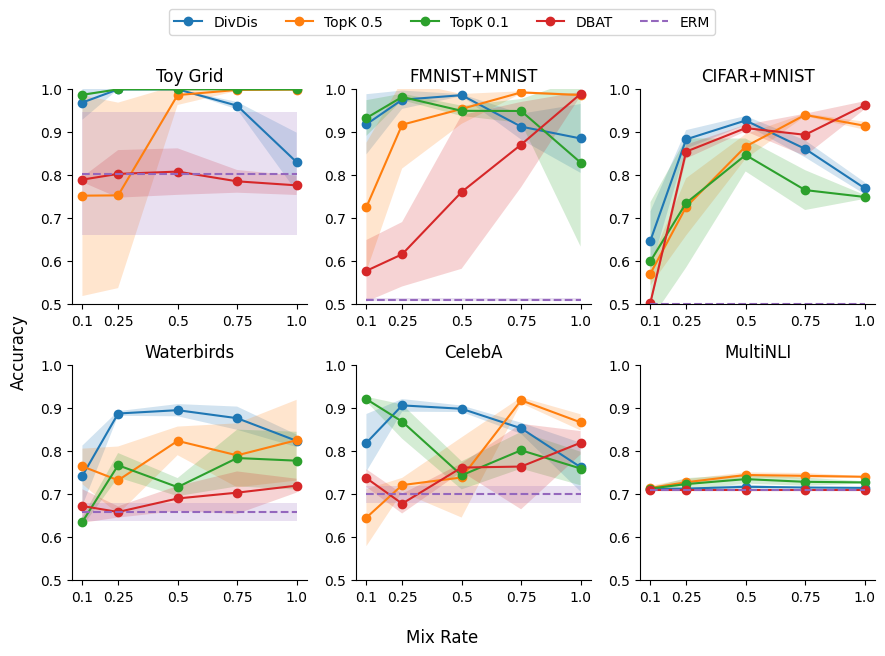

In [11]:
fig, axes = plot_acc_results_grid(acc_df, dataset_titles=DATASET_TITLES)
fig.savefig(f"{RESULTS_DIR}/cc_mix_rate.svg", bbox_inches="tight", dpi=300)
plt.show()

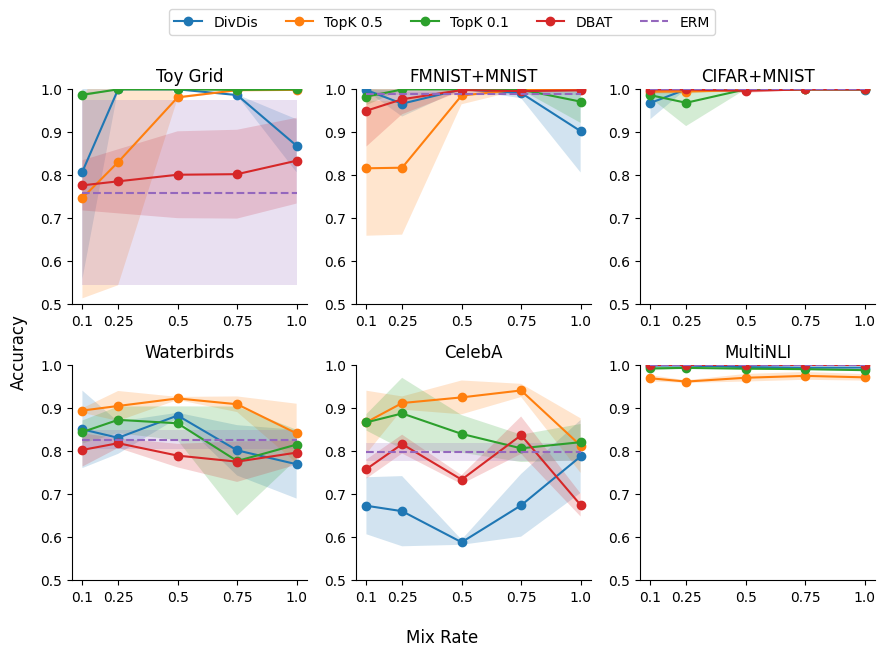

In [12]:
fig, axes = plot_acc_results_grid(alt_acc_df, dataset_titles=DATASET_TITLES)
fig.savefig(f"{RESULTS_DIR}/cc_mix_rate_alt.svg", bbox_inches="tight", dpi=300)
plt.show()

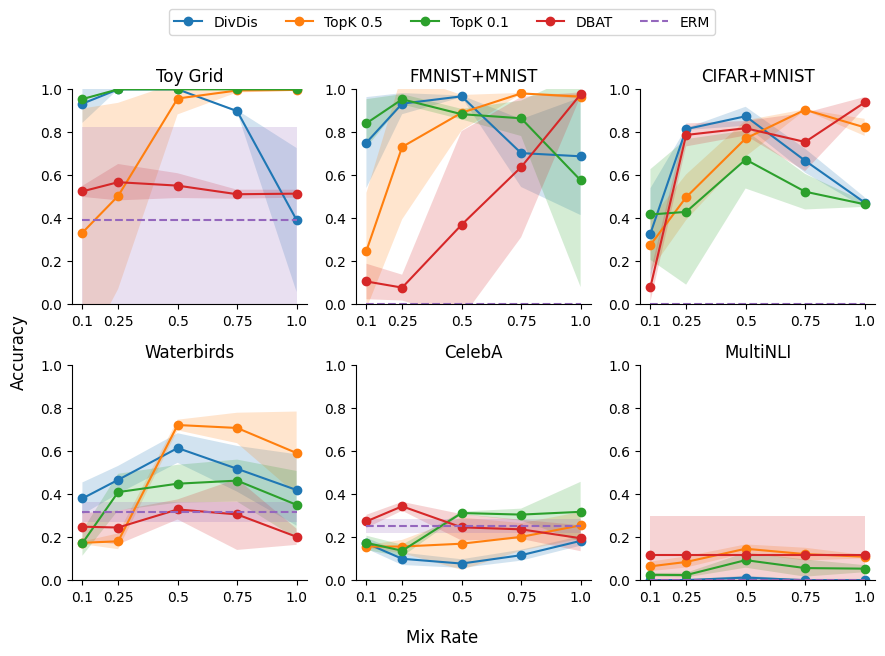

In [14]:
fig, axes = plot_acc_results_grid(worst_acc_df, dataset_titles=DATASET_TITLES, ylim=(0.0, 1.0))
fig.savefig(f"{RESULTS_DIR}/cc_mix_rate_worst.svg", bbox_inches="tight", dpi=300)
plt.show()